# Loading Libraries

In [121]:
import os
import random
from collections import defaultdict
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.serializers import CSVSerializer

# Load Dataset

In [2]:
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


# Split the dataset into Train, Validation, and Test Dataset

In [5]:
X = pd.DataFrame(digits["data"], columns=digits["feature_names"], dtype=np.int8)
y = pd.Series(digits["target"], name="target", dtype=np.int8)

In [6]:
# 80 (75% train - 25% val) - 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Showing samples

<Figure size 640x480 with 0 Axes>

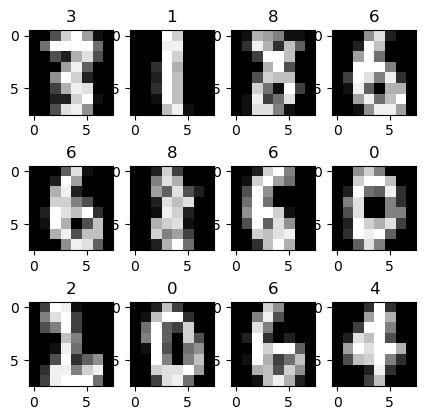

In [41]:
number_of_samples = len(digits["images"])
random_idx = random.sample(range(number_of_samples), k = 12)
images, targets = digits["images"][random_idx], digits["target"][random_idx]
plt.gray()
plt.figure(figsize=(5, 5))
for i, (img, y) in enumerate(zip(images, targets)):
    ax = plt.subplot(3, 4, i + 1)
    ax.imshow(img)
    ax.set_title(y)
plt.show()

# Classes frequencies

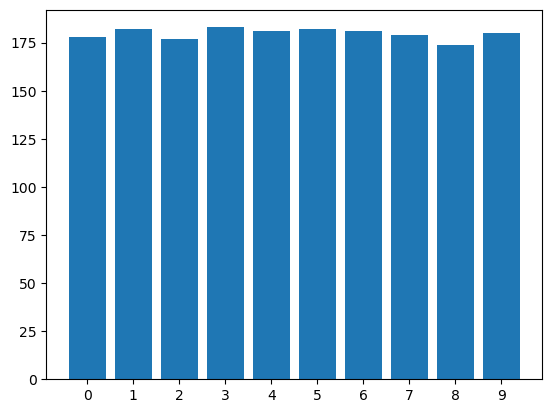

In [40]:
frequency = defaultdict(int)
for target in digits["target"]:
    frequency[str(target)] += 1

tick_label = list(frequency.keys())
height = list(frequency.values())
plt.bar(x=range(len(height)), height=height, tick_label=tick_label)
plt.show()

Append the target with the features for train, validation, and test datasets

Target variable: "digit" (1)
Features: "pixel_x_y" (64)

In [10]:
train = pd.concat([pd.Series(y_train, index=X_train.index,
                             name='digit', dtype=int), X_train], axis=1)
validation = pd.concat([pd.Series(y_val, index=X_val.index,
                            name='digit', dtype=int), X_val], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index,
                            name='digit', dtype=int), X_test], axis=1)

In [15]:
train

,digit,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
668,2,0,0,8,15,12,1,0,0,0,...,11,0,0,0,9,16,9,7,1,0
1005,6,0,0,2,14,5,0,0,0,0,...,11,0,0,0,3,12,16,15,4,0
269,3,0,0,6,15,16,10,0,0,0,...,5,0,0,0,9,16,16,8,0,0
1788,4,0,0,0,1,12,6,0,0,0,...,0,0,0,0,0,0,14,9,0,0
1263,6,0,0,0,12,16,1,0,0,0,...,16,5,0,0,1,11,16,16,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,4,0,0,0,3,13,7,0,0,0,...,0,0,0,0,0,2,15,4,0,0
207,2,0,0,5,14,11,0,0,0,0,...,0,0,0,0,7,16,12,7,0,0
1071,1,0,0,6,15,12,5,0,0,0,...,0,0,0,0,10,16,15,3,0,0
1338,2,0,0,10,16,14,6,0,0,0,...,6,1,0,0,12,16,14,13,16,8


In [12]:
validation

,digit,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
944,9,0,0,7,13,10,1,0,0,0,...,11,0,0,0,7,13,16,15,4,0
539,3,0,0,2,11,12,1,0,0,0,...,6,0,0,0,1,12,16,16,5,0
998,4,0,0,0,1,15,3,0,0,0,...,0,0,0,0,0,2,16,6,0,0
1060,9,0,0,12,14,6,0,0,0,0,...,0,0,0,0,13,9,8,2,0,0
159,9,0,0,5,13,4,0,0,0,0,...,4,0,0,0,6,12,13,10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,9,0,0,3,11,15,13,2,0,0,...,0,0,0,0,2,16,1,0,0,0
1585,1,0,0,0,13,9,0,0,0,0,...,0,0,0,0,0,12,15,0,0,0
1626,1,0,0,0,11,9,0,0,0,0,...,0,0,0,0,0,9,11,0,0,0
133,3,0,3,16,16,12,12,6,0,0,...,0,0,0,3,16,14,4,0,0,0


In [13]:
test

,digit,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
1245,6,0,0,0,7,12,0,0,0,0,...,16,2,0,0,0,9,14,14,5,0
220,9,0,0,11,16,8,0,0,0,0,...,0,0,0,0,13,16,11,1,0,0
1518,3,0,0,8,15,12,4,0,0,0,...,7,0,0,0,13,16,15,8,0,0
438,7,0,0,2,12,12,12,9,2,0,...,0,0,0,0,3,15,3,0,0,0
1270,2,0,2,13,16,10,0,0,0,0,...,14,0,0,3,15,16,16,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731,4,0,0,0,2,14,0,0,0,0,...,0,0,0,0,0,4,10,0,0,0
1630,3,0,0,6,16,15,5,0,0,0,...,0,0,0,0,6,16,16,12,1,0
1037,8,0,0,7,15,16,8,0,0,0,...,0,0,0,0,5,11,10,10,0,0
965,3,0,0,7,16,12,1,0,0,0,...,14,0,0,0,7,16,16,16,4,0


# Convert the train and validation datasets to csv files

In [55]:
# The first column is expected to be the "target" column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

# Upload the datasets to Amazon S3

In [32]:
region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
#print("RoleArn: {}".format(role))

AWS Region: us-east-2


In [33]:
bucket = sagemaker.Session().default_bucket()  # Using the default bucket

In [34]:
# It's important here has sagemaker in the name because of the IAM role
prefix = "demo-sagemaker-xgboost-digits-prediction"

In [57]:
# Upload the datasets to amazon using boto3 session to comunicate with the "S3"
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "data/train.csv")).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "data/validation.csv")).upload_file("validation.csv")

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


If we go to S3 in AWS Console we can see that create a new bucket with like this:

```
Buckets/sagemaker-us-east-2-<numbers_here>/demo-sagemaker-xgboost-digits-prediction/data/
├─ validation.csv
├─ train.csv
```

In [58]:
! aws s3 ls {bucket}/{prefix}/data --recursive

2023-09-09 02:56:51     158626 demo-sagemaker-xgboost-digits-prediction/data/train.csv
2023-09-09 02:56:51      53149 demo-sagemaker-xgboost-digits-prediction/data/validation.csv


# Train the model

We will use xgboost, but not importing the library... Here, we're using the [images_uris](https://sagemaker.readthedocs.io/en/stable/api/utility/image_uris.html)

In [84]:
s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')
container = sagemaker.image_uris.retrieve("xgboost", region, version="latest")
# print(container)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [60]:
xgb_model = sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

In [64]:
xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.5,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    num_class=10,
    objective = "multi:softmax",
    num_round = 10000,
    early_stopping_rounds=2
)

In [65]:
train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

In [66]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: xgboost-2023-09-09-03-02-35-496


2023-09-09 03:02:35 Starting - Starting the training job...
2023-09-09 03:03:01 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
.........
2023-09-09 03:04:21 Downloading - Downloading input data...
2023-09-09 03:05:02 Training - Downloading the training image...
2023-09-09 03:05:22 Training - Training image download completed. Training in progress..Arguments: train
[2023-09-09:03:05:33:INFO] Running standalone xgboost training.
[2023-09-09:03:05:33:INFO] File size need to be processed in the node: 0.2mb. Available memory size in the node: 8558.18mb
[2023-09-09:03:05:33:INFO] Determined delimiter of CSV input is ','
[03:05:33] S3DistributionType set as FullyReplicated
[03:05:33] 1077x64 matrix with 68928 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-09-09:03:05:33:INFO] Determined delimiter of CSV input is ','
[03:05:33] S3DistributionType set as FullyReplicated
[03:05:33] 360x64 matrix 

# Obtain the Debugger training reports

In [ ]:
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.job_name + "/rule-output" + "/ProfilerReport"
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

In [83]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("profiler-output/profiler-report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/profiler-output/profiler-report.html

In [ ]:
print(xgb_model.model_data)

# Deploy the Model

In [87]:
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: xgboost-2023-09-09-03-17-32-984
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-09-09-03-17-32-984
INFO:sagemaker:Creating endpoint with name xgboost-2023-09-09-03-17-32-984


-------!

In [88]:
print(xgb_predictor.endpoint_name)

xgboost-2023-09-09-03-17-32-984


# Evaluate the model

In [110]:
y_pred_string = xgb_predictor.predict(test.to_numpy()[:, 1:]).decode('utf-8')
y_pred = np.array([int(y) for y in np.fromstring(y_pred_string[1:], sep=',')], dtype=int)

In [125]:
acc = accuracy_score(y_true=test.to_numpy()[:, 0], y_pred=y_pred)
prec = precision_score(y_true=test.to_numpy()[:, 0], y_pred=y_pred, average="macro")
recall = recall_score(y_true=test.to_numpy()[:, 0], y_pred=y_pred, average="macro")
f1_score = f1_score(y_true=test.to_numpy()[:, 0], y_pred=y_pred, average="macro")

In [126]:
print("--- Model Metrics --- ")
print("accuracy = {:.4f}".format(acc))
print("precision (macro) = {:.4f}".format(prec))
print("recall (macro) = {:.4f}".format(recall))
print("f1_score (macro) = {:.4f}".format(f1_score))

--- Model Metrics --- 
accuracy = 0.9167
precision (macro) = 0.9167
recall (macro) = 0.9179
f1_score (macro) = 0.9153
